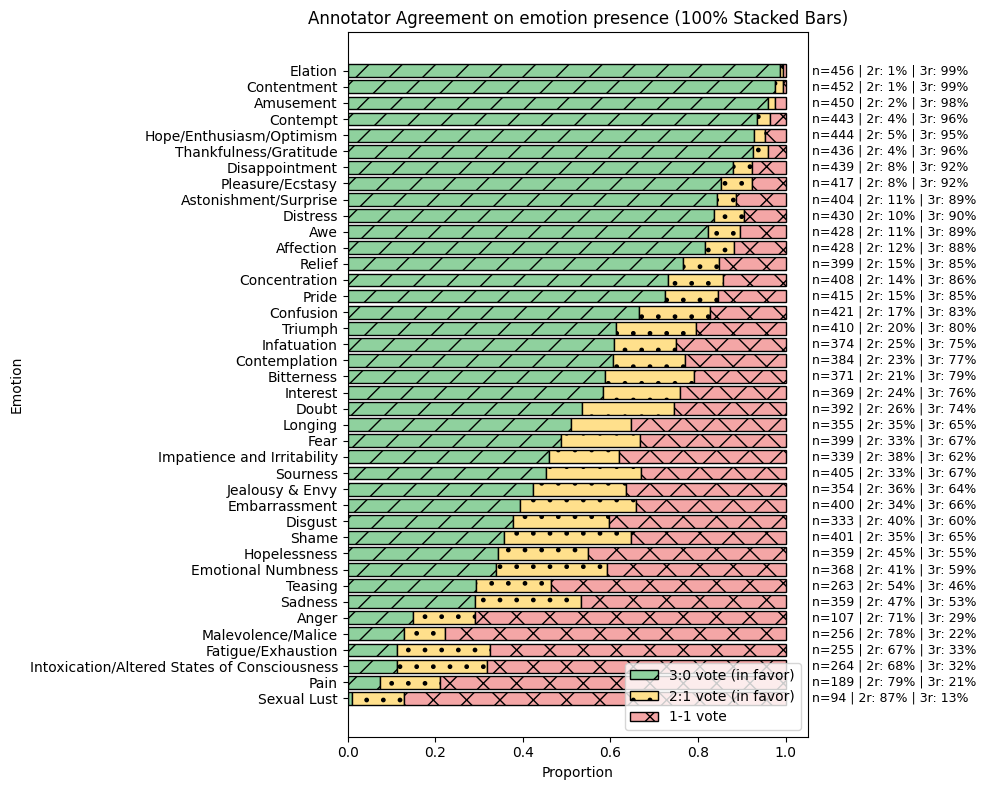

In [ ]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load binary annotation data
df = pd.read_csv("../data/binary.csv")

# Aggregate annotations by image path and emotion
df_agg = df.groupby(['path', 'emotion']).agg(lambda x: x.tolist()).reset_index()

# Keep only rows with more than one annotation (for agreement analysis)
df_agg = df_agg[df_agg['value'].map(len) > 1]

# Compute agreement score per row (proportion of True ratings)
df_agg['agreement'] = df_agg['value'].apply(lambda vals: sum(vals) / len(vals))

# Define function to classify agreement type for each annotation group
def agreement_type(values):
    n = len(values)
    n_true = sum(values)
    n_false = n - n_true
    if n == 2:
        # 2 annotators: full agreement or disagreement
        if n_true == 2 or n_false == 2:
            return 'agreement'
        else:
            return 'disagreement'
    elif n == 3:
        # 3 annotators: full agreement, partial (2:1), or full disagreement
        if n_true == 3 or n_false == 3:
            return 'agreement'
        elif n_true == 2 or n_false == 2:
            return 'partial'
        else:
            return 'disagreement'
    else:
        return 'other'

# Assign agreement type to each row
df_agg['agreement_type'] = df_agg['value'].apply(agreement_type)

# Get sorted list of emotions by median agreement (for plotting)
emotions = df_agg['emotion'].unique()
emotions_sorted = sorted(emotions, key=lambda emo: np.median(df_agg[df_agg['emotion'] == emo]['agreement']))

# Calculate proportion of each agreement type per emotion
data = []
for emo in emotions_sorted:
    subset = df_agg[df_agg['emotion'] == emo]
    total = len(subset)
    if total == 0:
        data.append({'emotion': emo, 'agreement': 0, 'partial': 0, 'disagreement': 0})
        continue
    counts = subset['agreement_type'].value_counts(normalize=True)
    data.append({
        'emotion': emo,
        'agreement': counts.get('agreement', 0),
        'partial': counts.get('partial', 0),
        'disagreement': counts.get('disagreement', 0)
    })

# Create DataFrame for plotting
plot_df = pd.DataFrame(data)

# Add n, %2-ratings, %3-ratings per emotion
def count_2_3_ratings(subset):
    n2 = (subset['value'].apply(len) == 2).sum()
    n3 = (subset['value'].apply(len) == 3).sum()
    total = len(subset)
    pct2 = 100 * n2 / total if total > 0 else 0
    pct3 = 100 * n3 / total if total > 0 else 0
    return total, pct2, pct3

n_list, pct2_list, pct3_list = [], [], []
for emo in plot_df['emotion']:
    subset = df_agg[df_agg['emotion'] == emo]
    n, pct2, pct3 = count_2_3_ratings(subset)
    n_list.append(n)
    pct2_list.append(pct2)
    pct3_list.append(pct3)
plot_df['n'] = n_list
plot_df['pct2'] = pct2_list
plot_df['pct3'] = pct3_list

# Sort by full agreement (ascending)
plot_df = plot_df.sort_values('agreement', ascending=True).reset_index(drop=True)

# Use color-blind friendly, less intense colors
colors = {
    'agreement': '#8fd19e',      # soft green
    'partial':   '#ffe08c',      # soft yellow
    'disagreement': '#f4a6a6'    # soft red
}
hatches = {'agreement': '/', 'partial': '.', 'disagreement': 'x'}
labels = {'agreement': '3:0 vote (in favor)', 'partial': '2:1 vote (in favor)', 'disagreement': '1-1 vote'}

fig, ax = plt.subplots(figsize=(10, 8))
bottom = np.zeros(len(plot_df))
bars = []
for key in ['agreement', 'partial', 'disagreement']:
    bar = ax.barh(
        plot_df['emotion'],
        plot_df[key],
        left=bottom,
        color=colors[key],
        label=labels[key],
        hatch=hatches[key],
        edgecolor='black'
    )
    bars.append(bar)
    bottom += plot_df[key]

# Add n, %2, %3 as text on the right of each bar
for i, (n, pct2, pct3) in enumerate(zip(plot_df['n'], plot_df['pct2'], plot_df['pct3'])):
    ax.text(
        1.01, i, 
        f"n={n} | 2r: {pct2:.0f}% | 3r: {pct3:.0f}%", 
        va='center', ha='left', fontsize=9, 
        color='black', 
        transform=ax.get_yaxis_transform()
    )

# Only show one legend entry per label
handles, legend_labels = [], []
for key, bar in zip(['agreement', 'partial', 'disagreement'], bars):
    handles.append(bar[0])
    legend_labels.append(labels[key])

ax.set_xlabel('Proportion')
ax.set_ylabel('Emotion')
ax.set_title('Annotator Agreement on emotion presence (100% Stacked Bars)')
ax.legend(handles, legend_labels, loc='lower right')
plt.tight_layout()
os.makedirs("./output", exist_ok=True)
plt.savefig("./output/annotator_agreement_stackedbars.png", dpi=600, bbox_inches='tight')
plt.show()